In [1]:
import numpy as np
import pickle
import random
from collections import defaultdict, Counter
from typing import List, Tuple, Dict, Set
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans  # For HMM hidden state clustering

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

### 1. Hidden Markov Model (HMM) Implementation

The HMM serves as the probabilistic oracle for our Hangman agent. It models the sequential nature of letter patterns in words and provides probability distributions over possible letters.

**Hidden States:** We used K-means clustering for 10 hidden states to group words of the same length based on letter frequency. Each cluster represents a hidden state that captures similar letter patterns like vowel placement, consonant patterns, etc.

**Emissions:**
- Emissions are position-specific letter probabilities: P(letter | state, position)
- Each state maintains a separate probability distribution for each position in the word.
- This captures positional dependencies (e.g., 'q' is more likely at the start, 'e' more common at the end),

**Training Algorithm:**
- **Baum-Welch (Forward-Backward) algorithm** with 5 iterations
- We trained separate HMMs for each word length (3-30 characters)
- K-means initialization provides better starting parameters than random initialization
- Laplace smoothing prevents zero probabilities for unseen letter-position combinations

In [2]:
class HangmanHMM:
    def __init__(self, n_states=10, max_length=30, n_iterations=5):
        self.n_states = n_states  # Number of hidden states
        self.max_length = max_length
        self.n_iterations = n_iterations  # Baum-Welch iterations

        # HMM parameters
        self.initial_probs = {}
        self.transition_probs = {}
        self.emission_probs = {}

        # Word patterns by length
        self.patterns_by_length = {}

    def _cluster_words_by_patterns(self, words, length):
        """Cluster words into hidden states based on letter patterns."""
        from sklearn.cluster import KMeans

        # Create feature vectors for words (letter frequency profiles)
        word_features = []
        valid_words = []

        for word in words:
            if len(word) == length:
                # Feature: letter frequency vector (26 dimensions)
                features = [word.count(chr(ord('a') + i)) for i in range(26)]
                word_features.append(features)
                valid_words.append(word)

        if len(valid_words) < self.n_states:
            # Too few words, use simple clustering
            n_clusters = min(len(valid_words), self.n_states)
        else:
            n_clusters = self.n_states

        if len(valid_words) == 0:
            return {}, []

        # K-means clustering to find hidden states
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(word_features)

        # Group words by cluster (hidden state)
        state_words = {i: [] for i in range(n_clusters)}
        for word, label in zip(valid_words, labels):
            state_words[label].append(word)

        return state_words, valid_words

    def _initialize_parameters(self, words, length, n_states):
        """Initialize HMM parameters before Baum-Welch."""
        alphabet = 'abcdefghijklmnopqrstuvwxyz'

        # Uniform initial probabilities
        self.initial_probs[length] = np.ones(n_states) / n_states

        # Uniform transition probabilities
        self.transition_probs[length] = np.ones((n_states, n_states)) / n_states

        # Initialize emission probabilities with smoothing
        self.emission_probs[length] = {}
        for state in range(n_states):
            self.emission_probs[length][state] = {}
            for pos in range(length):
                self.emission_probs[length][state][pos] = {}
                for letter in alphabet:
                    self.emission_probs[length][state][pos][letter] = 1.0 / 26

    def _forward_algorithm_training(self, word, length, n_states):
        """Forward algorithm for training - returns alpha and scaling factors."""
        T = len(word)
        alpha = np.zeros((T, n_states))
        c = np.zeros(T)  # Scaling factors

        # Initialization (t=0)
        for state in range(n_states):
            letter = word[0]
            emission_prob = self.emission_probs[length][state][0].get(letter, 1e-10)
            alpha[0][state] = self.initial_probs[length][state] * emission_prob

        # Scaling
        c[0] = np.sum(alpha[0])
        if c[0] > 0:
            alpha[0] = alpha[0] / c[0]

        # Recursion (t=1 to T-1)
        for t in range(1, T):
            letter = word[t]
            for state_j in range(n_states):
                prob_sum = 0
                for state_i in range(n_states):
                    prob_sum += alpha[t-1][state_i] * self.transition_probs[length][state_i][state_j]

                emission_prob = self.emission_probs[length][state_j][t].get(letter, 1e-10)
                alpha[t][state_j] = prob_sum * emission_prob

            # Scaling
            c[t] = np.sum(alpha[t])
            if c[t] > 0:
                alpha[t] = alpha[t] / c[t]

        return alpha, c

    def _backward_algorithm(self, word, length, n_states, c):
        """Backward algorithm - returns beta using same scaling factors."""
        T = len(word)
        beta = np.zeros((T, n_states))

        # Initialization (t=T-1)
        beta[T-1] = np.ones(n_states) / c[T-1]

        # Recursion (t=T-2 to 0)
        for t in range(T-2, -1, -1):
            letter = word[t+1]
            for state_i in range(n_states):
                prob_sum = 0
                for state_j in range(n_states):
                    emission_prob = self.emission_probs[length][state_j][t+1].get(letter, 1e-10)
                    prob_sum += self.transition_probs[length][state_i][state_j] * emission_prob * beta[t+1][state_j]

                beta[t][state_i] = prob_sum / c[t]

        return beta

    def _compute_gamma_xi(self, word, alpha, beta, length, n_states):
        """Compute gamma and xi for Baum-Welch."""
        T = len(word)

        # Gamma: P(state_t = i | O, λ)
        gamma = np.zeros((T, n_states))
        for t in range(T):
            denom = np.sum(alpha[t] * beta[t])
            if denom > 0:
                gamma[t] = (alpha[t] * beta[t]) / denom
            else:
                gamma[t] = np.ones(n_states) / n_states

        # Xi: P(state_t = i, state_{t+1} = j | O, λ)
        xi = np.zeros((T-1, n_states, n_states))
        for t in range(T-1):
            letter = word[t+1]
            denom = 0
            for i in range(n_states):
                for j in range(n_states):
                    emission_prob = self.emission_probs[length][j][t+1].get(letter, 1e-10)
                    xi[t][i][j] = alpha[t][i] * self.transition_probs[length][i][j] * emission_prob * beta[t+1][j]
                    denom += xi[t][i][j]

            if denom > 0:
                xi[t] = xi[t] / denom

        return gamma, xi

    def _baum_welch_iteration(self, words, length, n_states):
        """One iteration of Baum-Welch algorithm."""
        alphabet = 'abcdefghijklmnopqrstuvwxyz'

        # Accumulators
        gamma_sum_initial = np.zeros(n_states)
        gamma_sum = np.zeros(n_states)
        xi_sum = np.zeros((n_states, n_states))
        emission_counts = {}
        for state in range(n_states):
            emission_counts[state] = {}
            for pos in range(length):
                emission_counts[state][pos] = {letter: 0.0 for letter in alphabet}

        # E-step: compute expected counts
        for word in words:
            alpha, c = self._forward_algorithm_training(word, length, n_states)
            beta = self._backward_algorithm(word, length, n_states, c)
            gamma, xi = self._compute_gamma_xi(word, alpha, beta, length, n_states)

            # Accumulate initial probabilities
            gamma_sum_initial += gamma[0]

            # Accumulate transition probabilities
            for t in range(len(word) - 1):
                xi_sum += xi[t]

            # Accumulate emission probabilities
            for t in range(len(word)):
                letter = word[t]
                for state in range(n_states):
                    emission_counts[state][t][letter] += gamma[t][state]
                    gamma_sum[state] += gamma[t][state]

        # M-step: update parameters
        # Update initial probabilities
        total = np.sum(gamma_sum_initial)
        if total > 0:
            self.initial_probs[length] = gamma_sum_initial / total

        # Update transition probabilities with smoothing
        for i in range(n_states):
            row_sum = np.sum(xi_sum[i]) + n_states * 1e-10  # Laplace smoothing
            for j in range(n_states):
                self.transition_probs[length][i][j] = (xi_sum[i][j] + 1e-10) / row_sum

        # Update emission probabilities with smoothing
        for state in range(n_states):
            for pos in range(length):
                total = sum(emission_counts[state][pos].values()) + 26 * 1e-10
                for letter in alphabet:
                    self.emission_probs[length][state][pos][letter] = (emission_counts[state][pos][letter] + 1e-10) / total

    def train(self, corpus_file: str):
        print("Training HMM with Forward-Backward (Baum-Welch) algorithm...")

        # Read corpus
        with open(corpus_file, 'r') as f:
            words = [line.strip().lower() for line in f if line.strip()]

        print(f"Loaded {len(words)} words from corpus")

        # Train HMM for each word length
        for length in range(3, self.max_length + 1):
            length_words = [w for w in words if len(w) == length]

            if len(length_words) < 10:
                continue

            print(f"\nTraining length {length} ({len(length_words)} words)...")

            # Cluster words into hidden states (initialization)
            state_words, valid_words = self._cluster_words_by_patterns(length_words, length)

            if not state_words:
                continue

            n_states_actual = len(state_words)

            # Initialize parameters
            self._initialize_parameters(valid_words, length, n_states_actual)

            # Initial emission probabilities from clusters (better initialization)
            alphabet = 'abcdefghijklmnopqrstuvwxyz'
            for state_id, state_word_list in state_words.items():
                position_letter_counts = [{} for _ in range(length)]

                for word in state_word_list:
                    for pos, letter in enumerate(word):
                        position_letter_counts[pos][letter] = position_letter_counts[pos].get(letter, 0) + 1

                for pos in range(length):
                    total = sum(position_letter_counts[pos].values()) + 26
                    for letter in alphabet:
                        count = position_letter_counts[pos].get(letter, 0) + 1
                        self.emission_probs[length][state_id][pos][letter] = count / total

            # Run Baum-Welch iterations
            for iteration in range(self.n_iterations):
                self._baum_welch_iteration(valid_words, length, n_states_actual)
                if (iteration + 1) % 2 == 0:
                    print(f"  Iteration {iteration + 1}/{self.n_iterations} completed")

        print(f"\nHMM trained on {len(self.emission_probs)} different word lengths")
        print(f"Using Forward-Backward algorithm with {self.n_iterations} iterations")

    def _forward_algorithm(self, masked_word, guessed_letters, length):
        """Forward algorithm for inference (prediction)."""
        if length not in self.emission_probs:
            return None

        n_states = len(self.emission_probs[length])
        alpha = np.zeros((len(masked_word), n_states))

        # Initialization (t=0)
        for state in range(n_states):
            if masked_word[0] != '_':
                # Observed letter
                letter = masked_word[0]
                alpha[0][state] = (self.initial_probs[length][state] *
                                  self.emission_probs[length][state][0].get(letter, 1e-10))
            else:
                # Unknown position - sum over all possible letters
                alpha[0][state] = self.initial_probs[length][state]

        # Normalize
        alpha[0] = alpha[0] / (np.sum(alpha[0]) + 1e-10)

        # Recursion (t=1 to T-1)
        for t in range(1, len(masked_word)):
            for state_j in range(n_states):
                prob_sum = 0
                for state_i in range(n_states):
                    prob_sum += alpha[t-1][state_i] * self.transition_probs[length][state_i][state_j]

                if masked_word[t] != '_':
                    # Observed letter
                    letter = masked_word[t]
                    emission_prob = self.emission_probs[length][state_j][t].get(letter, 1e-10)
                else:
                    emission_prob = 1.0  # Unknown position

                alpha[t][state_j] = prob_sum * emission_prob

            # Normalize to prevent underflow
            alpha[t] = alpha[t] / (np.sum(alpha[t]) + 1e-10)

        return alpha

    def predict(self, masked_word: str, guessed_letters: Set[str]) -> Dict[str, float]:
        """Predict letter probabilities using Forward algorithm."""
        length = len(masked_word)

        if length not in self.emission_probs:
            # Fallback to uniform distribution
            available = [l for l in 'abcdefghijklmnopqrstuvwxyz' if l not in guessed_letters]
            return {l: 1.0/len(available) for l in available}

        # Run forward algorithm
        alpha = self._forward_algorithm(masked_word, guessed_letters, length)

        if alpha is None:
            available = [l for l in 'abcdefghijklmnopqrstuvwxyz' if l not in guessed_letters]
            return {l: 1.0/len(available) for l in available}

        # Get final state probabilities
        final_state_probs = alpha[-1]

        # Calculate letter probabilities by marginalizing over states
        letter_scores = Counter()

        for pos, char in enumerate(masked_word):
            if char == '_':  # Unknown position
                for state_id, state_prob in enumerate(final_state_probs):
                    for letter in 'abcdefghijklmnopqrstuvwxyz':
                        if letter not in guessed_letters:
                            emission_prob = self.emission_probs[length][state_id][pos].get(letter, 1e-10)
                            letter_scores[letter] += state_prob * emission_prob

        # Normalize
        total = sum(letter_scores.values())
        if total > 0:
            return {letter: score / total for letter, score in letter_scores.items()}
        else:
            available = [l for l in 'abcdefghijklmnopqrstuvwxyz' if l not in guessed_letters]
            return {l: 1.0/len(available) for l in available}

    def save(self, filepath: str):
        """Save trained HMM to file."""
        with open(filepath, 'wb') as f:
            pickle.dump({
                'initial_probs': self.initial_probs,
                'transition_probs': self.transition_probs,
                'emission_probs': self.emission_probs,
                'n_states': self.n_states,
                'max_length': self.max_length,
                'n_iterations': self.n_iterations
            }, f)
        print(f"HMM saved to {filepath}")

    @staticmethod
    def load(filepath: str):
        """Load trained HMM from file."""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        hmm = HangmanHMM(n_states=data['n_states'], max_length=data['max_length'],
                         n_iterations=data.get('n_iterations', 5))
        hmm.initial_probs = data['initial_probs']
        hmm.transition_probs = data['transition_probs']
        hmm.emission_probs = data['emission_probs']
        return hmm

print("HangmanHMM class defined (with Forward-Backward Baum-Welch algorithm).")


HangmanHMM class defined (with Forward-Backward Baum-Welch algorithm).


### 2. Train HMM on Cleaned Corpus

In [4]:
def clean_corpus(input_file, output_file):
    cleaned_words = set()

    with open(input_file, 'r', encoding='utf-8') as infile:
        for line in infile:
            word = line.strip().lower()  # remove whitespace and convert to lowercase

            # Keep only words with lowercase English letters (a-z)
            if word.isalpha():
                cleaned_words.add(word)

    # Sort words alphabetically before saving
    cleaned_words = sorted(cleaned_words)

    with open(output_file, 'w', encoding='utf-8') as outfile:
        for word in cleaned_words:
            outfile.write(word + '\n')

    print(f"{len(cleaned_words)} unique valid words saved to {output_file}.")

clean_corpus("corpus.txt", "cleaned_corpus.txt")


49397 unique valid words saved to cleaned_corpus.txt.


In [5]:
# Initialize and train HMM with clean corpus (we removed duplicates and whitespaces)
hmm = HangmanHMM(max_length=30)
hmm.train('cleaned_corpus.txt')

# Save the trained model
import os
os.makedirs('models', exist_ok=True)
hmm.save('models/hangman_hmm_cleaned.pkl')

print("\nHMM training completed with cleaned corpus.")

Training HMM with Forward-Backward (Baum-Welch) algorithm...
Loaded 49397 words from corpus

Training length 3 (310 words)...
  Iteration 2/5 completed
  Iteration 4/5 completed

Training length 4 (1077 words)...
  Iteration 2/5 completed
  Iteration 4/5 completed

Training length 5 (2154 words)...
  Iteration 2/5 completed
  Iteration 4/5 completed

Training length 6 (3716 words)...
  Iteration 2/5 completed
  Iteration 4/5 completed

Training length 7 (5038 words)...
  Iteration 2/5 completed
  Iteration 4/5 completed

Training length 8 (6306 words)...
  Iteration 2/5 completed
  Iteration 4/5 completed

Training length 9 (6778 words)...
  Iteration 2/5 completed
  Iteration 4/5 completed

Training length 10 (6454 words)...
  Iteration 2/5 completed
  Iteration 4/5 completed

Training length 11 (5437 words)...
  Iteration 2/5 completed
  Iteration 4/5 completed

Training length 12 (4292 words)...
  Iteration 2/5 completed
  Iteration 4/5 completed

Training length 13 (3094 words)...


### 3. Hangman Game Environment

This environment simulates the Hangman game mechanics and provides the interface for our RL agent.
- Maximum 6 wrong guesses allowed per game
- Tracks masked word state, guessed letters, and wrong guess count
- Returns rewards based on actions taken

**Reward Structure:**
- **+6** for correct letter guess
- **-3** for incorrect letter guess
- **+25** for winning the game (word fully revealed)
- **-10** for losing the game (6 wrong guesses reached)
- **0** for repeated guesses (no penalty, but counted separately for scoring)

## 3. Hangman Game Environment

In [6]:
class HangmanEnvironment:
    def __init__(self, word: str, max_wrong: int = 6):
        self.word = word.lower()
        self.max_wrong = max_wrong
        self.reset()

    def reset(self) -> Tuple[str, Set[str], int]:
        """Reset game to initial state."""
        self.guessed_letters = set()
        self.wrong_guesses = 0
        self.repeated_guesses = 0
        self.masked_word = '_' * len(self.word)
        return (self.masked_word, self.guessed_letters, self.wrong_guesses)

    def step(self, letter: str) -> Tuple[Tuple[str, Set[str], int], int, bool]:
        """Take a step in the game with the following rewards:
        +6 correct letter; -3 wrong letter; +25 win; -10 loss. No other rewards/penalties.
        """
        letter = letter.lower()

        # Repeated guess: no reward/penalty, continue
        if letter in self.guessed_letters:
            self.repeated_guesses += 1
            return (self.masked_word, self.guessed_letters, self.wrong_guesses), 0, False

        self.guessed_letters.add(letter)

        # Correct guess
        if letter in self.word:
            # Reveal letter in masked word
            new_masked = ''
            for i, char in enumerate(self.word):
                if char == letter:
                    new_masked += letter
                else:
                    new_masked += self.masked_word[i]
            self.masked_word = new_masked

            # Check for win
            if '_' not in self.masked_word:
                return (self.masked_word, self.guessed_letters, self.wrong_guesses), 25, True

            return (self.masked_word, self.guessed_letters, self.wrong_guesses), 6, False
        else:
            # Wrong guess
            self.wrong_guesses += 1

            # Check for loss
            if self.wrong_guesses >= self.max_wrong:
                return (self.masked_word, self.guessed_letters, self.wrong_guesses), -10, True

            return (self.masked_word, self.guessed_letters, self.wrong_guesses), -3, False

print("HangmanEnvironment class defined.")

HangmanEnvironment class defined.


### 4. Reinforcement Learning Agent Design

**Algorithm:** Q-Learning with hybrid strategy combination

**State Representation:**
The state is a tuple: `(masked_word, guessed_letters, wrong_guesses)`
- `masked_word`: Current word with underscores for unknown letters (e.g., "_PP_E")
- `guessed_letters`: Set of already guessed letters
- `wrong_guesses`: Count of incorrect guesses so far (0-6)

**Action Space:**
- 26 possible actions (one for each letter a-z)
- Only available actions (unguessed letters) are considered

**Reward Function:**
Designed to maximize wins while minimizing mistakes:
- Correct guess: +6 (immediate positive reinforcement)
- Wrong guess: -3 (penalty for error)
- Win game: +25 (strong terminal reward)
- Lose game: -10 (terminal penalty)
- Repeated guess: 0 (no reward/penalty, but tracked)

**Q-Learning Parameters:**
- Learning rate (α): 0.15 - moderate updates to Q-values
- Discount factor (γ): 0.9 - values future rewards highly
- Epsilon (ε): 1.0 to 0.05 - starts with full exploration, decays to 5% exploration
- Epsilon decay: 0.9975 - gradual transition from exploration to exploitation

**Exploration vs Exploitation:**
- ε-greedy strategy with exponential decay
- High initial exploration (ε=1.0) to discover good strategies
- Gradual decay (0.9975 per episode) to exploit learned knowledge
- Minimum exploration (ε=0.05) maintained for robustness

In [7]:
class HangmanQLearningAgent:
    def __init__(self, hmm, corpus_words: List[str] = None,
                 learning_rate: float = 0.15,
                 discount_factor: float = 0.9,
                 epsilon: float = 1.0,
                 epsilon_decay: float = 0.9975,
                 epsilon_min: float = 0.05):
        self.hmm = hmm
        self.corpus_words = corpus_words or []
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        # Q-table
        self.q_table = defaultdict(lambda: defaultdict(float))

        # Build word index by length for faster filtering
        self.words_by_length = defaultdict(list)
        for word in self.corpus_words:
            self.words_by_length[len(word)].append(word)

        # Precompute global letter frequencies
        self.global_letter_freq = Counter()
        for word in self.corpus_words:
            for letter in set(word):
                self.global_letter_freq[letter] += 1

        # Common letter order (English frequency)
        self.common_letters = 'etaoinshrdlcumwfgypbvkjxqz'

    def _get_state_key(self, masked_word: str, guessed_letters: Set[str],
                       wrong_guesses: int) -> str:
        """Create state key for Q-table."""
        pattern = masked_word
        n_guessed = len(guessed_letters)
        return f"{pattern}:{n_guessed}:{wrong_guesses}"

    def _filter_words(self, masked_word: str, guessed_letters: Set[str]) -> List[str]:
        """Filter corpus words that match the current pattern."""
        length = len(masked_word)
        candidates = self.words_by_length.get(length, [])

        matching_words = []
        for word in candidates:
            # Check if word matches the pattern
            matches = True
            for i, char in enumerate(masked_word):
                if char != '_' and word[i] != char:
                    matches = False
                    break

            if not matches:
                continue

            # Check if word contains any guessed letters in wrong positions
            for letter in guessed_letters:
                if letter in masked_word:
                    continue  # Already revealed
                if letter in word:
                    matches = False
                    break

            if matches:
                matching_words.append(word)

        return matching_words

    def _get_letter_frequencies(self, words: List[str], guessed: Set[str], masked_word: str) -> Dict[str, float]:
        """ADVANCED letter frequency with multiple strategies."""
        if not words:
            return {}

        letter_scores = Counter()
        unknown_positions = [i for i, c in enumerate(masked_word) if c == '_']

        # Strategy 1: Word coverage (how many words contain this letter)
        for word in words:
            unique_letters = set(word)
            for letter in unique_letters:
                if letter not in guessed:
                    letter_scores[letter] += 10  # Base coverage score

        # Strategy 2: Position-specific frequency (STRONG weight)
        if unknown_positions:
            for pos in unknown_positions:
                position_counts = Counter()
                for word in words:
                    if pos < len(word):
                        letter = word[pos]
                        if letter not in guessed:
                            position_counts[letter] += 1

                # Add position-specific scores with HIGH weight
                for letter, count in position_counts.items():
                    letter_scores[letter] += count * 20  # 2x weight for position match

        # Strategy 3: Penalize rare letters if many options exist
        if len(words) > 5:
            avg_freq = sum(letter_scores.values()) / len(letter_scores) if letter_scores else 1
            for letter in letter_scores:
                if letter_scores[letter] < avg_freq * 0.3:  # Very rare
                    letter_scores[letter] *= 0.5  # Reduce score

        # Strategy 4: Boost vowels early in the game
        if len(guessed) < 3:
            for vowel in 'aeiou':
                if vowel in letter_scores and vowel not in guessed:
                    letter_scores[vowel] *= 1.3  # Boost vowels early

        total = sum(letter_scores.values())
        if total == 0:
            return {}

        return {letter: score / total for letter, score in letter_scores.items()}

    def choose_action(self, state: Tuple, training: bool = True) -> str:
        masked_word, guessed_letters, wrong_guesses = state
        available_actions = [letter for letter in 'abcdefghijklmnopqrstuvwxyz'
                            if letter not in guessed_letters]

        if not available_actions:
            return 'a'

        # Minimal exploration during training
        if training and random.random() < self.epsilon:
            return random.choice(available_actions)

        matching_words = self._filter_words(masked_word, guessed_letters)
        filter_scores = {}

        if matching_words:
            filter_scores = self._get_letter_frequencies(matching_words, guessed_letters, masked_word)
        elif len(available_actions) > 0:
            if len(guessed_letters) == 0:
                # First guess: always 'e' (most common)
                return 'e' if 'e' in available_actions else available_actions[0]

            # Use global frequencies
            total = sum(self.global_letter_freq.get(l, 1) for l in available_actions)
            if total > 0:
                filter_scores = {l: self.global_letter_freq.get(l, 1) / total for l in available_actions}

        hmm_scores = self.hmm.predict(masked_word, guessed_letters)

        state_key = self._get_state_key(masked_word, guessed_letters, wrong_guesses)
        q_scores = {}
        if state_key in self.q_table:
            max_q = max(self.q_table[state_key].values()) if self.q_table[state_key] else 0
            min_q = min(self.q_table[state_key].values()) if self.q_table[state_key] else 0
            if max_q > min_q:
                for letter in available_actions:
                    q_val = self.q_table[state_key].get(letter, 0)
                    q_scores[letter] = (q_val - min_q) / (max_q - min_q)


        combined_scores = {}
        for letter in available_actions:
            score = 0
            score += filter_scores.get(letter, 0) * 0.10
            score += hmm_scores.get(letter, 0) * 0.60
            score += q_scores.get(letter, 0) * 0.30
            combined_scores[letter] = score

        if combined_scores:
            return max(combined_scores.items(), key=lambda x: x[1])[0]
        else:
            # common letters
            for letter in self.common_letters:
                if letter in available_actions:
                    return letter
            return available_actions[0]

    def update_q_value(self, state: Tuple, action: str, reward: int,
                       next_state: Tuple, done: bool):
        """Update Q-value using Q-learning formula."""
        masked_word, guessed_letters, wrong_guesses = state
        state_key = self._get_state_key(masked_word, guessed_letters, wrong_guesses)

        if done:
            max_next_q = 0
        else:
            next_masked, next_guessed, next_wrong = next_state
            next_key = self._get_state_key(next_masked, next_guessed, next_wrong)
            max_next_q = max(self.q_table[next_key].values()) if self.q_table[next_key] else 0

        old_q = self.q_table[state_key][action]
        new_q = old_q + self.learning_rate * (reward + self.discount_factor * max_next_q - old_q)
        self.q_table[state_key][action] = new_q

    def decay_epsilon(self):
        """Decay exploration rate."""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def save(self, filepath: str):
        """Save agent to file."""
        data = {
            'q_table': dict(self.q_table),
            'epsilon': self.epsilon,
            'learning_rate': self.learning_rate,
            'discount_factor': self.discount_factor
        }
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)
        print(f"Agent saved to {filepath}")

print("HangmanQLearningAgent class defined.")

HangmanQLearningAgent class defined.


### 5. Train the Agent

In [8]:
with open('cleaned_corpus.txt', 'r') as f:
    corpus_words = [line.strip().lower() for line in f if line.strip()]

print(f"Loaded {len(corpus_words)} words for training")

agent = HangmanQLearningAgent(
    hmm=hmm,
    corpus_words=corpus_words,
    learning_rate=0.15,
    discount_factor=0.9,
    epsilon=1.0,
    epsilon_decay=0.9975,
    epsilon_min=0.05
)

# Training parameters
n_episodes = 5000
save_interval = 500

# Metrics
episode_rewards = []
episode_wins = []
episode_wrong_guesses = []
episode_repeated_guesses = []

print(f"\nTraining agent for {n_episodes} episodes...")
print("="*60)

for episode in range(n_episodes):
    word = random.choice(corpus_words)
    env = HangmanEnvironment(word, max_wrong=6)

    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.choose_action(state, training=True)
        next_state, reward, done = env.step(action)
        agent.update_q_value(state, action, reward, next_state, done)
        total_reward += reward
        state = next_state

    agent.decay_epsilon()

    episode_rewards.append(total_reward)
    episode_wins.append(1 if '_' not in env.masked_word else 0)
    episode_wrong_guesses.append(env.wrong_guesses)
    episode_repeated_guesses.append(env.repeated_guesses)

    if (episode + 1) % save_interval == 0:
        recent_wins = sum(episode_wins[-save_interval:])
        recent_reward = np.mean(episode_rewards[-save_interval:])
        recent_wrong = np.mean(episode_wrong_guesses[-save_interval:])
        print(f"Episode {episode+1}/{n_episodes} | "
              f"Win Rate: {recent_wins/save_interval:.1%} | "
              f"Avg Reward: {recent_reward:.1f} | "
              f"Avg Wrong: {recent_wrong:.2f} | "
              f"ε: {agent.epsilon:.3f}")

print("\n" + "="*60)
print("Training completed.")
agent.save('models/hangman_agent.pkl')

final_win_rate = sum(episode_wins[-1000:]) / 1000
final_avg_wrong = np.mean(episode_wrong_guesses[-1000:])
print(f"\nFinal Win Rate (last 1000 episodes): {final_win_rate:.1%}")
print(f"Avg Wrong Guesses (last 1000 episodes): {final_avg_wrong:.2f}")

Loaded 49397 words for training

Training agent for 5000 episodes...
Episode 500/5000 | Win Rate: 22.2% | Avg Reward: 11.3 | Avg Wrong: 5.44 | ε: 0.286
Episode 1000/5000 | Win Rate: 61.2% | Avg Reward: 36.3 | Avg Wrong: 4.11 | ε: 0.082
Episode 1500/5000 | Win Rate: 75.6% | Avg Reward: 44.1 | Avg Wrong: 3.46 | ε: 0.050
Episode 2000/5000 | Win Rate: 69.0% | Avg Reward: 41.7 | Avg Wrong: 3.63 | ε: 0.050
Episode 2500/5000 | Win Rate: 71.2% | Avg Reward: 42.7 | Avg Wrong: 3.63 | ε: 0.050
Episode 3000/5000 | Win Rate: 71.2% | Avg Reward: 42.8 | Avg Wrong: 3.58 | ε: 0.050
Episode 3500/5000 | Win Rate: 72.0% | Avg Reward: 42.4 | Avg Wrong: 3.59 | ε: 0.050
Episode 4000/5000 | Win Rate: 73.8% | Avg Reward: 43.7 | Avg Wrong: 3.46 | ε: 0.050
Episode 4500/5000 | Win Rate: 74.4% | Avg Reward: 44.0 | Avg Wrong: 3.36 | ε: 0.050
Episode 5000/5000 | Win Rate: 76.4% | Avg Reward: 44.6 | Avg Wrong: 3.48 | ε: 0.050

Training completed.
Agent saved to models/hangman_agent.pkl

Final Win Rate (last 1000 epis

### Training Loop

**Training Configuration:**
- Episodes: 5,000 games
- Corpus: 49,397 cleaned words
- Environment: Max 6 wrong guesses per game
- Agent: Q-Learning with HMM and word filtering

**Training Process:** For each episode:
   - Select random word from corpus
   - Reset environment
   - Agent interacts with environment until game ends
   - Update Q-values using Q-learning update rule
   - Decay exploration rate (epsilon)

### 6. Plots of the agent's learning

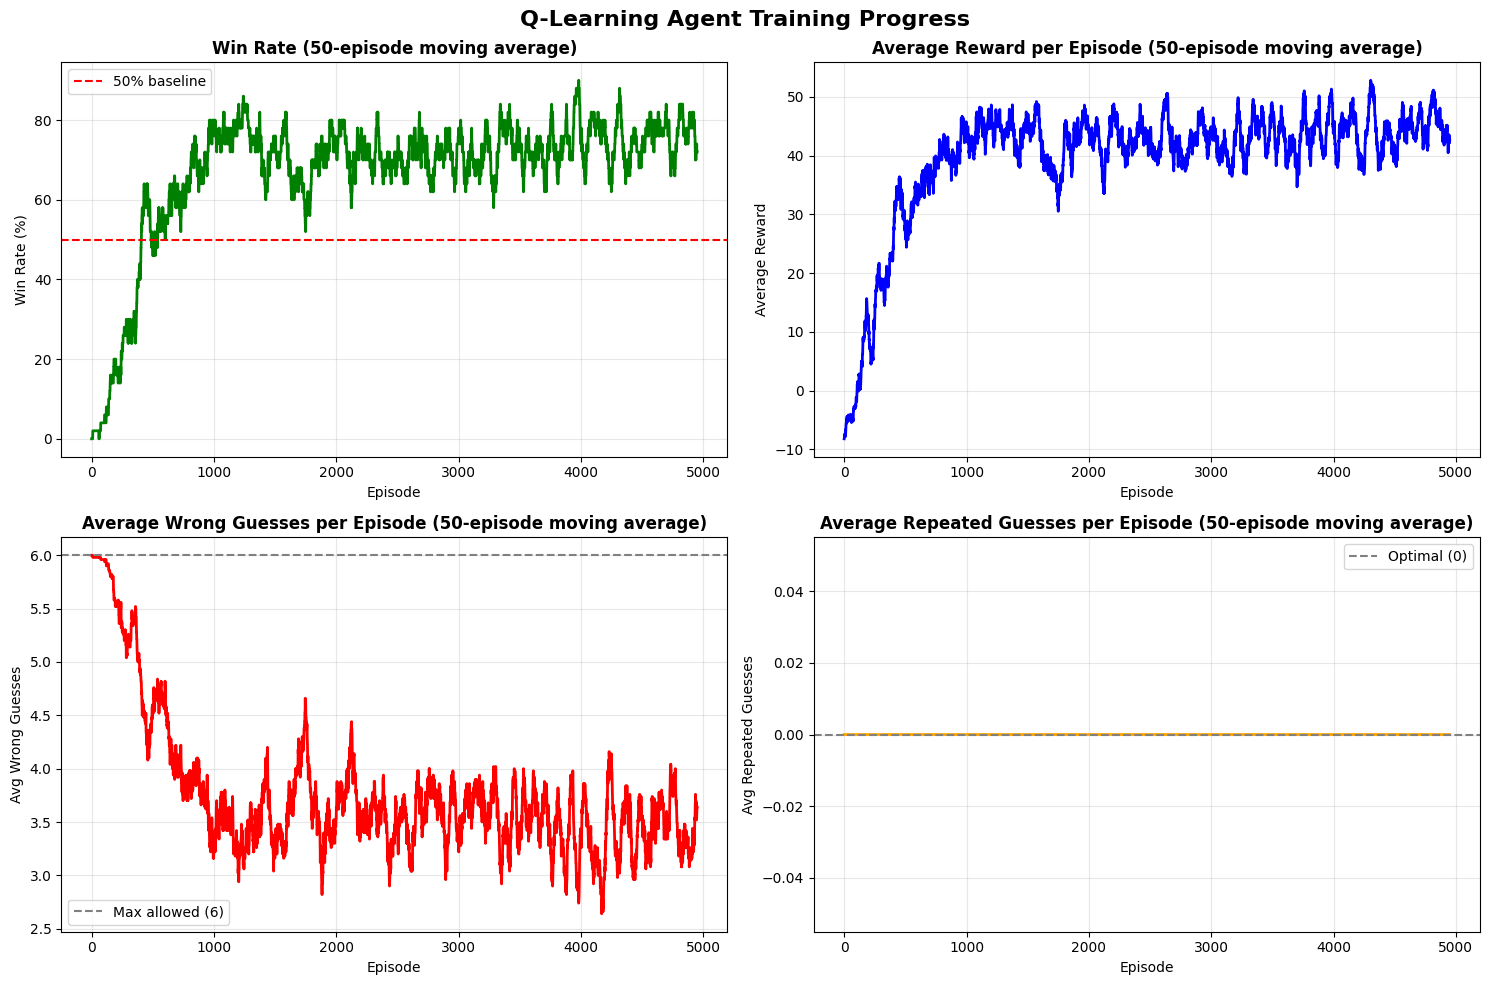

In [9]:
# Plot training metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Moving average window
window = 50

# Win Rate
win_rate_ma = np.convolve(episode_wins, np.ones(window)/window, mode='valid')
axes[0, 0].plot(win_rate_ma * 100, color='green', linewidth=2)
axes[0, 0].axhline(y=50, color='red', linestyle='--', label='50% baseline')
axes[0, 0].set_title('Win Rate (50-episode moving average)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Win Rate (%)')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Average Reward
reward_ma = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
axes[0, 1].plot(reward_ma, color='blue', linewidth=2)
axes[0, 1].set_title('Average Reward per Episode (50-episode moving average)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Average Reward')
axes[0, 1].grid(alpha=0.3)

# Wrong Guesses
wrong_ma = np.convolve(episode_wrong_guesses, np.ones(window)/window, mode='valid')
axes[1, 0].plot(wrong_ma, color='red', linewidth=2)
axes[1, 0].axhline(y=6, color='gray', linestyle='--', label='Max allowed (6)')
axes[1, 0].set_title('Average Wrong Guesses per Episode (50-episode moving average)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Avg Wrong Guesses')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Repeated Guesses
repeated_ma = np.convolve(episode_repeated_guesses, np.ones(window)/window, mode='valid')
axes[1, 1].plot(repeated_ma, color='orange', linewidth=2)
axes[1, 1].axhline(y=0, color='gray', linestyle='--', label='Optimal (0)')
axes[1, 1].set_title('Average Repeated Guesses per Episode (50-episode moving average)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Avg Repeated Guesses')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Q-Learning Agent Training Progress', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 7. Evaluation on Test Set

In [10]:
# Load test words
with open('test.txt', 'r') as f:
    test_words = [line.strip().lower() for line in f if line.strip()]

print(f"Loaded {len(test_words)} test words.")

Loaded 2000 test words.


In [11]:
print("Evaluating agent on test set...")
print("="*60)

test_wins = 0
test_total_wrong = 0
test_total_repeated = 0
test_results = []

for i, word in enumerate(test_words):
    env = HangmanEnvironment(word, max_wrong=6)
    state = env.reset()
    done = False

    while not done:
        action = agent.choose_action(state, training=False)
        state, reward, done = env.step(action)

    # Record results
    won = 1 if '_' not in env.masked_word else 0
    test_wins += won
    test_total_wrong += env.wrong_guesses
    test_total_repeated += env.repeated_guesses

    test_results.append({
        'word': word,
        'won': won,
        'wrong_guesses': env.wrong_guesses,
        'repeated_guesses': env.repeated_guesses
    })

    # Progress update
    if (i + 1) % 500 == 0:
        print(f"Progress: {i+1}/{len(test_words)} | Win Rate: {test_wins/(i+1):.1%}")

# Calculate metrics
success_rate = (test_wins / len(test_words))*100
avg_wrong = test_total_wrong / len(test_words)
avg_repeated = test_total_repeated / len(test_words)

final_score = (success_rate * 2000) - (test_total_wrong * 5) - (test_total_repeated * 2)

print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"Games Played: {len(test_words)}")
print(f"Success Rate: {success_rate:.4f} ({test_wins}/{len(test_words)})")
print(f"Average Wrong Guesses: {avg_wrong:.2f}")
print(f"Average Repeated Guesses: {avg_repeated:.2f}")
print(f"Total Wrong Guesses: {test_total_wrong}")
print(f"Total Repeated Guesses: {test_total_repeated}")
print("\n" + "="*60)
print(f"FINAL SCORE: {final_score:.2f}")
print("="*60)

Evaluating agent on test set...
Progress: 500/2000 | Win Rate: 21.6%
Progress: 1000/2000 | Win Rate: 21.5%
Progress: 1500/2000 | Win Rate: 20.8%
Progress: 2000/2000 | Win Rate: 20.9%

EVALUATION RESULTS
Games Played: 2000
Success Rate: 20.9000 (418/2000)
Average Wrong Guesses: 5.53
Average Repeated Guesses: 0.00
Total Wrong Guesses: 11067
Total Repeated Guesses: 0

FINAL SCORE: -13535.00
